In [1]:
import requests
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pathlib
import tarfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-02-04 14:20:48.658360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading Data

In [2]:
url = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"
r = requests.get(url, allow_redirects=True)
open("cora.tgz", "wb").write(r.content)

168052

Extracting and reading data

In [3]:
tarball_path = pathlib.Path("datasets/housing.tgz")
if not tarball_path.is_file():
    pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
    with tarfile.open("cora.tgz") as datafile:
        datafile.extractall(path="datasets")
citationdata = pd.read_csv(pathlib.Path("datasets/cora/cora.cites"), sep="\t",header=None, names=["target", "source"],)
citationdata.sample(frac=1)

,target,source
2609,28336,108047
3628,74937,74920
5414,817774,820661
1506,7419,1113182
4197,136768,136766
...,...,...
3915,97390,33907
4086,123825,42847
2994,38845,1107010
157,35,81722


Adding column names and extracting paper data

In [4]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
paperdata = pd.read_csv(pathlib.Path("datasets/cora/cora.content"), sep="\t", header=None, names=column_names,)
paperdata.shape

(2708, 1435)

In [5]:
paperdata.sample(20)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
1941,126926,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
1622,1000012,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rule_Learning
1432,1107674,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
196,232606,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rule_Learning
2684,115188,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
1963,55403,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Rule_Learning
2285,643695,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
592,648112,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
2206,593942,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2697,626530,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [6]:
paperdata[["subject"]].value_counts()

subject               
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
dtype: int64

In [7]:
class_values = sorted(paperdata["subject"].unique())
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [8]:
class_idx = {name: id for id, name in enumerate(class_values)}
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [9]:
paper_idx = {name: idx for idx, name in enumerate(sorted(paperdata["paper_id"].unique()))}
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

Paper indexes are random, so we map the paper indexes to numbers starting from 0

In [10]:
paperdata["paper_id"] = paperdata["paper_id"].apply(lambda name: paper_idx[name])
paperdata["subject"] = paperdata["subject"].apply(lambda value: class_idx[value])
citationdata["source"] = citationdata["source"].apply(lambda name: paper_idx[name])
citationdata["target"] = citationdata["target"].apply(lambda name: paper_idx[name])

In [11]:
paperdata.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Visualising a sample of the data

In [12]:
plt.figure(figsize=(10,10))
colors = paperdata["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citationdata.sample(n=150))
subjects = list(paperdata[paperdata["paper_id"].isin(list(cora_graph.nodes))]["subject"])
subjects

[0,
 4,
 4,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 3,
 6,
 0,
 3,
 3,
 2,
 2,
 2,
 6,
 2,
 3,
 2,
 6,
 1,
 2,
 5,
 6,
 1,
 2,
 4,
 0,
 0,
 2,
 0,
 2,
 0,
 3,
 0,
 1,
 4,
 5,
 4,
 3,
 2,
 6,
 5,
 1,
 3,
 5,
 6,
 2,
 1,
 5,
 2,
 6,
 6,
 4,
 3,
 0,
 4,
 2,
 2,
 4,
 4,
 6,
 2,
 0,
 0,
 4,
 2,
 4,
 3,
 2,
 0,
 6,
 3,
 5,
 2,
 6,
 4,
 1,
 3,
 2,
 2,
 2,
 5,
 2,
 2,
 1,
 4,
 2,
 0,
 2,
 0,
 3,
 2,
 4,
 2,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 6,
 2,
 6,
 3,
 3,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 6,
 5,
 4,
 6,
 4,
 4,
 1,
 2,
 2,
 3,
 3,
 2,
 2,
 1,
 1,
 5,
 6,
 6,
 1,
 5,
 1,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 0,
 1,
 4,
 2,
 6,
 2,
 3,
 6,
 0,
 4,
 4,
 2,
 2,
 2,
 0,
 2,
 6,
 3,
 0,
 5,
 2,
 2,
 2,
 4,
 1,
 1,
 1,
 3,
 3,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 1,
 6,
 4,
 1,
 1,
 4,
 3,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 3,
 3,
 4,
 6,
 1,
 6,
 4,
 6,
 3,
 2,
 2,
 0,
 0,
 3,
 1,
 2,
 1,
 2,
 0,
 2,
 4,
 3,
 4,
 1,
 5,
 2,
 2,
 5,
 2,
 0,
 1,
 2,
 2,
 0,
 5,
 1,
 2,
 3,
 6,
 6,
 6,
 1,
 2,
 2,
 0,
 3,
 2,
 2,
 2,
 2,


<Figure size 1000x1000 with 0 Axes>

In [13]:
#nx.draw_spring(cora_graph, node_size = 15, node_colour = subjects)

In [14]:
#nx.drawing.layout.spring_layout(cora_graph)

In [15]:
paperdata.groupby("subject")

Stratified sample of the data, stratified from the different subjects of the papers

In [16]:
train_data, test_data = [], []

for _, group_data in paperdata.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2155, 1435)
Test data shape: (553, 1435)


Setting some universal hyperparameters

In [17]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 256

Define function to train model

In [18]:
def run_exp(model, x_train, y_train):
    model.compile(optimizer = keras.optimizers.Adam(learning_rate), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")])
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
    history = model.fit(x=x_train,y=y_train,epochs=num_epochs,batch_size=batch_size,validation_split=0.15,callbacks=[early_stopping])
    return history

Plots for accuracy and loss vs epochs

In [19]:
def plot_learning_curve(history):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

Method to define a new function to define a new feedforward network layer

In [20]:
def createffn(hidden_units, dropout_rate, name=None):
    fnnlayers = []
    for units in hidden_units:
        fnnlayers.append(layers.BatchNormalization())
        fnnlayers.append(layers.Dropout(dropout_rate))
        fnnlayers.append(layers.Dense(units, activation=tf.nn.gelu))
    return keras.Sequential(fnnlayers, name=name)

In [21]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [22]:
paper_idx

{35: 0,
 40: 1,
 114: 2,
 117: 3,
 128: 4,
 130: 5,
 164: 6,
 288: 7,
 424: 8,
 434: 9,
 463: 10,
 504: 11,
 506: 12,
 887: 13,
 906: 14,
 910: 15,
 936: 16,
 940: 17,
 941: 18,
 943: 19,
 1026: 20,
 1033: 21,
 1034: 22,
 1035: 23,
 1213: 24,
 1237: 25,
 1246: 26,
 1272: 27,
 1365: 28,
 1385: 29,
 1481: 30,
 1688: 31,
 1694: 32,
 1717: 33,
 1786: 34,
 1817: 35,
 1919: 36,
 1949: 37,
 1951: 38,
 1952: 39,
 1953: 40,
 1955: 41,
 1956: 42,
 1959: 43,
 1997: 44,
 1999: 45,
 2354: 46,
 2440: 47,
 2653: 48,
 2654: 49,
 2658: 50,
 2663: 51,
 2665: 52,
 2695: 53,
 2696: 54,
 2698: 55,
 2702: 56,
 3084: 57,
 3085: 58,
 3095: 59,
 3097: 60,
 3101: 61,
 3112: 62,
 3187: 63,
 3191: 64,
 3192: 65,
 3217: 66,
 3218: 67,
 3220: 68,
 3222: 69,
 3223: 70,
 3229: 71,
 3231: 72,
 3232: 73,
 3233: 74,
 3235: 75,
 3236: 76,
 3237: 77,
 3240: 78,
 3243: 79,
 3828: 80,
 3932: 81,
 4274: 82,
 4329: 83,
 4330: 84,
 4335: 85,
 4553: 86,
 4584: 87,
 4637: 88,
 4649: 89,
 4660: 90,
 4804: 91,
 4878: 92,
 4983: 93

Defining some utility variables, and training data for baseline model

In [23]:
featurenames = set(paperdata.columns) - {"paper_id","subject"}
nfeatures = len(featurenames)
nclasses = len(class_idx)
x_train = train_data[featurenames].to_numpy()
x_test = test_data[featurenames].to_numpy()

y_train = train_data["subject"]
y_test = test_data["subject"]


/tmp/ipykernel_296/362588152.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[featurenames].to_numpy()
/tmp/ipykernel_296/362588152.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[featurenames].to_numpy()


Baseline model definition
Input layer, 5 feed forward layers with residual connections, then the logit layer for classitifcation

In [24]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(nfeatures,), name="input_features")
    x = createffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = createffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, nclasses, dropout_rate)
baseline_model.summary()

2023-02-04 14:21:03.774786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 14:21:03.778855: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [34]:
history = run_exp(baseline_model, x_train, y_train)

Epoch 1/100
8/8 [==============================] - 5s 130ms/step - loss: 0.6124 - acc: 0.7914 - val_loss: 0.6156 - val_acc: 0.7901
Epoch 2/100
8/8 [==============================] - 0s 55ms/step - loss: 0.6076 - acc: 0.7837 - val_loss: 0.5966 - val_acc: 0.7932
Epoch 3/100
8/8 [==============================] - 0s 55ms/step - loss: 0.5916 - acc: 0.7985 - val_loss: 0.5854 - val_acc: 0.7994
Epoch 4/100
8/8 [==============================] - 1s 63ms/step - loss: 0.5722 - acc: 0.7957 - val_loss: 0.6136 - val_acc: 0.7809
Epoch 5/100
8/8 [==============================] - 0s 44ms/step - loss: 0.6054 - acc: 0.7870 - val_loss: 0.6248 - val_acc: 0.7747
Epoch 6/100
8/8 [==============================] - 0s 48ms/step - loss: 0.5730 - acc: 0.7957 - val_loss: 0.6296 - val_acc: 0.7963
Epoch 7/100
8/8 [==============================] - 0s 45ms/step - loss: 0.5941 - acc: 0.7848 - val_loss: 0.6272 - val_acc: 0.7901
Epoch 8/100
8/8 [==============================] - 0s 60ms/step - loss: 0.5766 - acc: 0.8

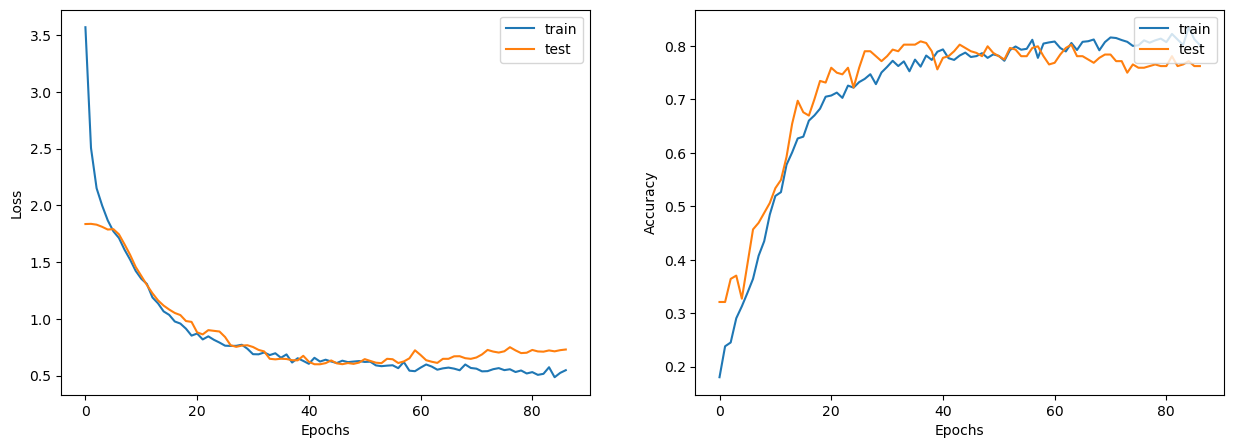

In [26]:
plot_learning_curve(history)

Testing Accuracy on Test set

In [27]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 75.77%


Generating random data

In [28]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)

def display_class_probabilities(probabilities):
     for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

Testing on randomly generated data

In [35]:
new_instances = generate_random_instances(10)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 420ms/step
Instance 1:
- Case_Based: 3.48%
- Genetic_Algorithms: 0.59%
- Neural_Networks: 2.52%
- Probabilistic_Methods: 1.11%
- Reinforcement_Learning: 0.53%
- Rule_Learning: 1.72%
- Theory: 90.05%
Instance 2:
- Case_Based: 3.91%
- Genetic_Algorithms: 4.38%
- Neural_Networks: 17.38%
- Probabilistic_Methods: 35.29%
- Reinforcement_Learning: 24.84%
- Rule_Learning: 7.07%
- Theory: 7.12%
Instance 3:
- Case_Based: 11.01%
- Genetic_Algorithms: 7.32%
- Neural_Networks: 18.86%
- Probabilistic_Methods: 0.84%
- Reinforcement_Learning: 0.56%
- Rule_Learning: 31.55%
- Theory: 29.86%
Instance 4:
- Case_Based: 0.24%
- Genetic_Algorithms: 1.13%
- Neural_Networks: 94.49%
- Probabilistic_Methods: 1.33%
- Reinforcement_Learning: 0.45%
- Rule_Learning: 0.8%
- Theory: 1.56%
Instance 5:
- Case_Based: 2.59%
- Genetic_Algorithms: 2.88%
- Neural_Networks: 13.89%
- Probabilistic_Methods: 3.69%
- Reinforcement_Learning: 59.39%
- Rule_Learning: 4.54%
- Theory: 13.02%
I

In [30]:
new_instances.shape

(10, 1433)

Adding new instances to data

In [40]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citationdata[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(paperdata.sort_values("paper_id")[featurenames].to_numpy(), dtype=tf.dtypes.float32)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

/tmp/ipykernel_296/110880912.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  paperdata.sort_values("paper_id")[featurenames].to_numpy(), dtype=tf.dtypes.float32


Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


Defining Layer class for GCN, initialisation function, prepare does the message creation, aggregate combines messages from neighbours, update carries out message passing

In [74]:

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = createffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = createffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


Define classifier class, input layer, 3 ff layers with residuals, logit layer

In [75]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = createffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = createffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


Initialising model

In [76]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=7,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
print("GNN output shape:", gnn_model([10,10,10]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.08783431 -0.13146755 -0.12908976 -0.14695802 -0.046903    0.08992931
  -0.05994305]
 [-0.08783431 -0.13146755 -0.12908976 -0.14695802 -0.046903    0.08992931
  -0.05994305]
 [-0.08783431 -0.13146755 -0.12908976 -0.14695802 -0.046903    0.08992931
  -0.05994305]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

Training GNN

In [77]:
x_train = train_data.paper_id.to_numpy()
history = run_exp(gnn_model, x_train, y_train)

/home/divijkhaitan/anaconda3/envs/gnnenv/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
8/8 [==============================] - 10s 266ms/step - loss: 2.2513 - acc: 0.1879 - val_loss: 1.8884 - val_acc: 0.3179
Epoch 2/100
8/8 [==============================] - 1s 172ms/step - loss: 1.9874 - acc: 0.2698 - val_loss: 1.8427 - val_acc: 0.3210
Epoch 3/100
8/8 [==============================] - 2s 199ms/step - loss: 1.8812 - acc: 0.2824 - val_loss: 1.8425 - val_acc: 0.3210
Epoch 4/100
8/8 [==============================] - 2s 211ms/step - loss: 1.8571 - acc: 0.2851 - val_loss: 1.8359 - val_acc: 0.3210
Epoch 5/100
8/8 [==============================] - 2s 185ms/step - loss: 1.8479 - acc: 0.2829 - val_loss: 1.8318 - val_acc: 0.3210
Epoch 6/100
8/8 [==============================] - 2s 204ms/step - loss: 1.8464 - acc: 0.3004 - val_loss: 1.8232 - val_acc: 0.3210
Epoch 7/100
8/8 [==============================] - 1s 174ms/step - loss: 1.8377 - acc: 0.2998 - val_loss: 1.8092 - val_acc: 0.3210
Epoch 8/100
8/8 [==============================] - 2s 225ms/step - loss: 1.8075 - 

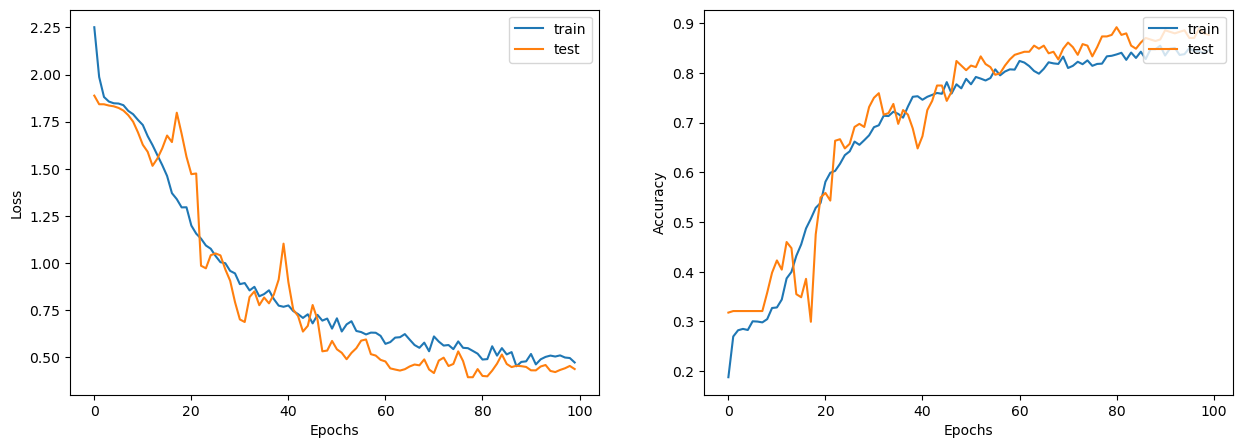

In [78]:
plot_learning_curve(history)

Testing Model

In [79]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 83.91%


Testing on random data, observe that the most likely outcome from the baseline has a greater probability in each of the new instances, i.e. the GCN is better than the baseline model

In [80]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(nclasses)]
new_citations = []
for subject_idx, group in paperdata.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(paperdata.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [81]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2718, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 4s 4s/step
Instance 1:
- Case_Based: 72.67%
- Genetic_Algorithms: 1.26%
- Neural_Networks: 1.28%
- Probabilistic_Methods: 0.83%
- Reinforcement_Learning: 0.76%
- Rule_Learning: 13.76%
- Theory: 9.44%
Instance 2:
- Case_Based: 0.71%
- Genetic_Algorithms: 87.22%
- Neural_Networks: 1.22%
- Probabilistic_Methods: 1.59%
- Reinforcement_Learning: 8.48%
- Rule_Learning: 0.12%
- Theory: 0.65%
Instance 3:
- Case_Based: 0.47%
- Genetic_Algorithms: 2.14%
- Neural_Networks: 81.4%
- Probabilistic_Methods: 4.56%
- Reinforcement_Learning: 0.64%
- Rule_Learning: 0.69%
- Theory: 10.1%
Instance 4:
- Case_Based: 0.15%
- Genetic_Algorithms: 0.28%
- Neural_Networks: 9.78%
- Probabilistic_Methods: 84.07%
- Reinforcement_Learning: 0.13%
- Rule_Learning: 0.07%
- Theory: 5.52%
Instance 5:
- Case_Based: 0.33%
- Genetic_Algorithms: 0.69